# Simple Classifiers - Generative AI Detection CLEF 2025

In this notebook we try to use some hand-crafted features to detect AI-generated text. We will look at the following features:

- Average sentence length  
- Average document length
- Average world length
- Lexical diversity (type-token ratio TTR)
- Stopword ratio
- Punctuation density
- Use of rare words (IDF)

Afterwards, we use these indicators to train a simple statistical model, such as a Random Forest.

In [1]:
from medaidml import DATA_TRAIN_JSON, DATA_TEST_JSON

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import json

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, roc_curve
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

nltk.download('stopwords')
nltk.download('punkt')

def load_data(path):
    with open(path, 'r', encoding='utf-8') as f:
        data = json.load(f)
    df = pd.DataFrame(data)
    return df

full_df = load_data(DATA_TRAIN_JSON)

train_df, temp_df = train_test_split(full_df, test_size=0.3, random_state=777)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=777)

no_dataleak_test_df = load_data(DATA_TEST_JSON)

labels = {
    0: "Human",
    1: "AI"
}
colors = ["green", "red"]

len(train_df), len(val_df), len(test_df), len(no_dataleak_test_df)

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/patrickstyll/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /home/patrickstyll/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


(7554, 1619, 1619, 2500)

## Document Length

In general, most AI-generated texts seem to be smaller than human-written texts, i.e. in terms of having more tokens in a document, with a token being a whitespace-delimited sequence of characters.

In [2]:
def classify_by_avg_doc_length(dataframe, labels_mapping):
    doc_lengths = [(len(row['text'].split()), labels_mapping[row['target']]) for _, row in dataframe.iterrows()]  # -> (len, label)
    lengths, labels_list = zip(*doc_lengths)

    labels_binary = [1 if label == 'AI' else 0 for label in labels_list]
    fpr, tpr, thresholds = roc_curve(labels_binary, lengths)
    optimal_idx = abs(tpr - fpr).argmax()
    threshold = thresholds[optimal_idx]

    predictions = ['AI' if length <= threshold else 'Human' for length in lengths]
    correct_predictions = sum(1 for pred, actual in zip(predictions, labels_list) if pred == actual)
    accuracy = correct_predictions / len(labels_list)

    plt.figure(figsize=(10, 6))
    plt.hist([lengths[i] for i in range(len(lengths)) if labels_list[i] == 'AI'], bins=50, alpha=0.5, label='AI', color='r', density=True)
    plt.hist([lengths[i] for i in range(len(lengths)) if labels_list[i] == 'Human'], bins=50, alpha=0.5, label='Human', color='b', density=True)
    plt.axvline(x=threshold, color='k', linestyle='--', label=f'Threshold ({int(threshold)}); Accuracy: {accuracy:.2%}')
    plt.title(f'Document Length (Accuracy: {accuracy:.2%})')
    plt.xlabel('Number of Tokens')
    plt.ylabel('Density')
    plt.legend()
    plt.show()

    return threshold, accuracy

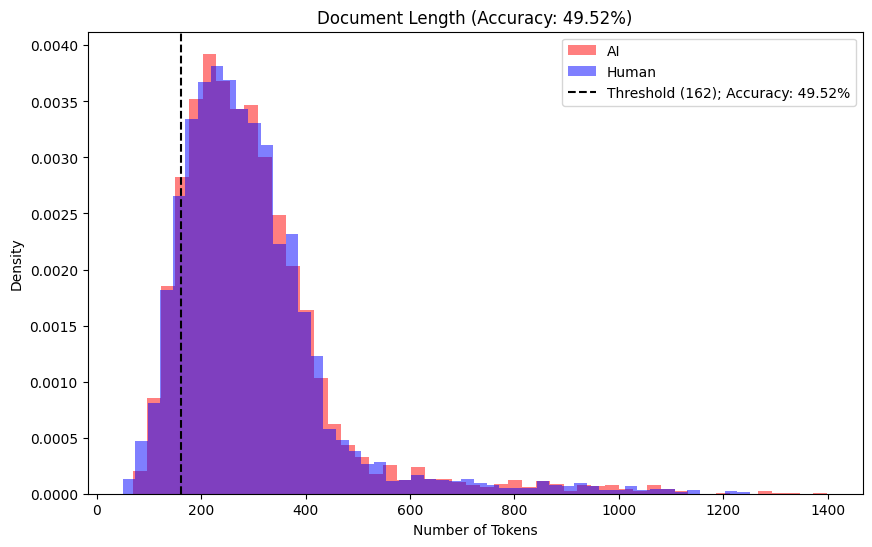

(np.float64(162.0), 0.49523431294678316)

In [3]:
classify_by_avg_doc_length(train_df, labels)

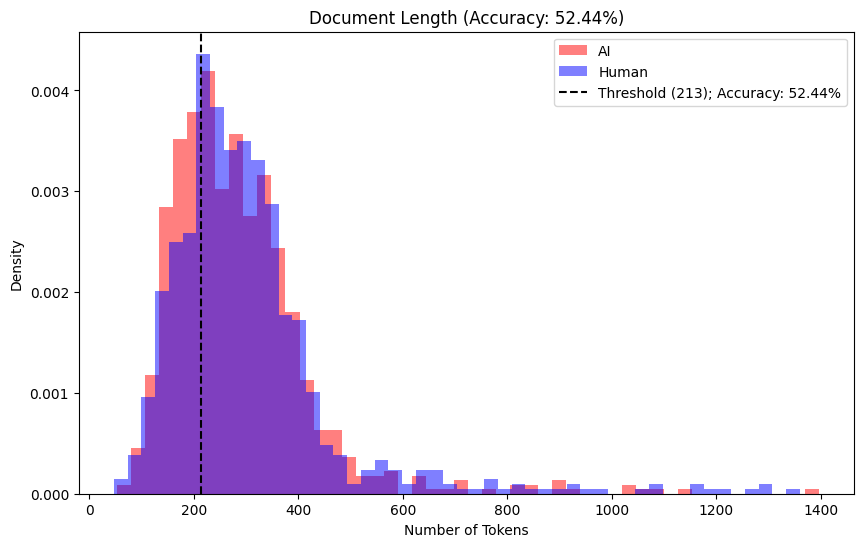

(np.float64(213.0), 0.5243977764051884)

In [4]:
classify_by_avg_doc_length(val_df, labels)

## Average Sentence Length

Humans and machines seem to generate sentences of similar lengths (according to number of tokens), but (surprisingly) machine generated sentences seem to be shorter. For simplification purposes, sentences are defined by being delimited by a dot.

In [5]:
def classify_by_avg_sentence_length(dataframe, labels_mapping):
    avg_sentence_lengths = []
    for _, row in dataframe.iterrows():
        sentences = row['text'].split('.')
        avg_length = sum(len(sentence.split()) for sentence in sentences if sentence.strip()) / len(sentences)
        avg_sentence_lengths.append((avg_length, labels_mapping[row['target']]))  # -> (avg_length, label)

    lengths, labels_list = zip(*avg_sentence_lengths)
    labels_binary = [1 if label == 'AI' else 0 for label in labels_list]
    fpr, tpr, thresholds = roc_curve(labels_binary, lengths)
    optimal_idx = abs(tpr - fpr).argmax()
    threshold = thresholds[optimal_idx]

    predictions = ['AI' if length <= threshold else 'Human' for length in lengths]
    correct_predictions = sum(1 for pred, actual in zip(predictions, labels_list) if pred == actual)
    accuracy = correct_predictions / len(labels_list)

    plt.figure(figsize=(10, 6))
    plt.hist([lengths[i] for i in range(len(lengths)) if labels_list[i] == 'AI'], bins=50, alpha=0.5, label='AI', color='r', density=True)
    plt.hist([lengths[i] for i in range(len(lengths)) if labels_list[i] == 'Human'], bins=50, alpha=0.5, label='Human', color='b', density=True)
    plt.axvline(x=threshold, color='k', linestyle='--', label=f'Threshold ({threshold:.2f}); Accuracy: {accuracy:.2%}')
    plt.title(f'Average Sentence Length (Accuracy: {accuracy:.2%})')
    plt.xlabel('Number of Tokens per Sentence')
    plt.ylabel('Density')
    plt.legend()
    plt.show()

    return threshold, accuracy

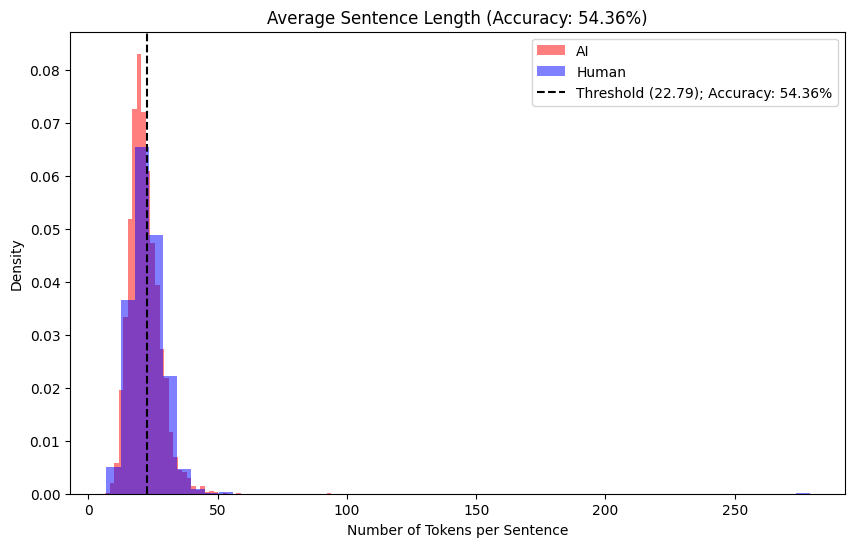

(np.float64(22.785714285714285), 0.543553084458565)

In [6]:
classify_by_avg_sentence_length(train_df, labels)

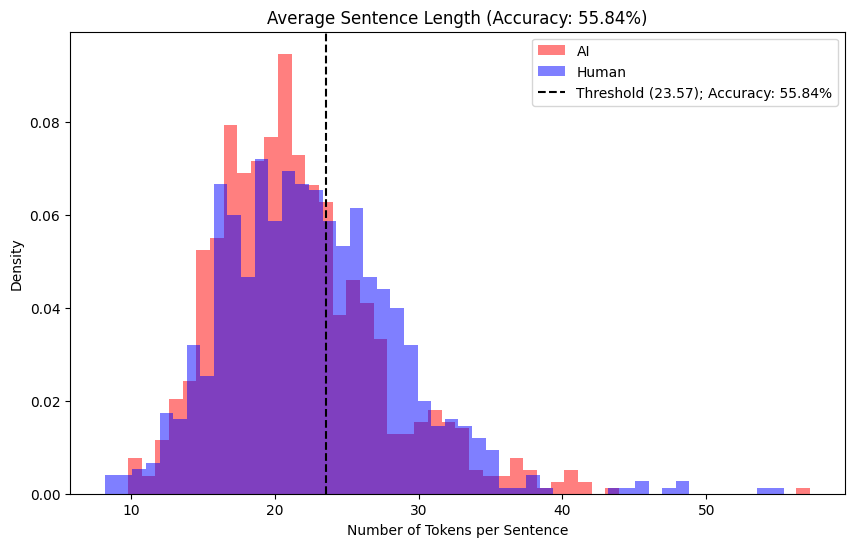

(np.float64(23.571428571428573), 0.5583693638048178)

In [7]:
classify_by_avg_sentence_length(val_df, labels)

## Average Word Length

The average word length seems to be significant, with AI usually generating longer tokens (words).

In [8]:
def classify_by_avg_word_length(dataframe, labels_mapping):
    avg_word_lengths = []
    for _, row in dataframe.iterrows():
        words = row['text'].split()
        avg_length = sum(len(word) for word in words) / len(words) if words else 0
        avg_word_lengths.append((avg_length, labels_mapping[row['target']]))  # -> (avg_length, label)

    lengths, labels_list = zip(*avg_word_lengths)
    labels_binary = [1 if label == 'AI' else 0 for label in labels_list]
    fpr, tpr, thresholds = roc_curve(labels_binary, lengths)
    optimal_idx = abs(tpr - fpr).argmax()
    threshold = thresholds[optimal_idx]

    predictions = ['AI' if length >= threshold else 'Human' for length in lengths]
    correct_predictions = sum(1 for pred, actual in zip(predictions, labels_list) if pred == actual)
    accuracy = correct_predictions / len(labels_list)

    plt.figure(figsize=(10, 6))
    plt.hist([lengths[i] for i in range(len(lengths)) if labels_list[i] == 'AI'], bins=50, alpha=0.5, label='AI', color='r', density=True)
    plt.hist([lengths[i] for i in range(len(lengths)) if labels_list[i] == 'Human'], bins=50, alpha=0.5, label='Human', color='b', density=True)
    plt.axvline(x=threshold, color='k', linestyle='--', label=f'Threshold ({threshold:.2f}); Accuracy: {accuracy:.2%}')
    plt.title(f'Average Word Length (Accuracy: {accuracy:.2%})')
    plt.xlabel('Number of Characters per Word')
    plt.ylabel('Density')
    plt.legend()
    plt.show()

    return threshold, accuracy

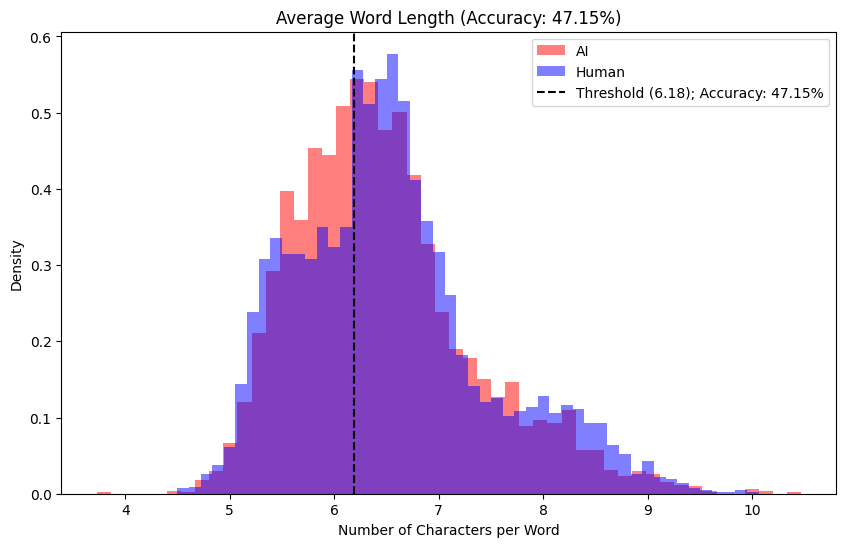

(np.float64(6.184549356223176), 0.4715382578766217)

In [9]:
classify_by_avg_word_length(train_df, labels)

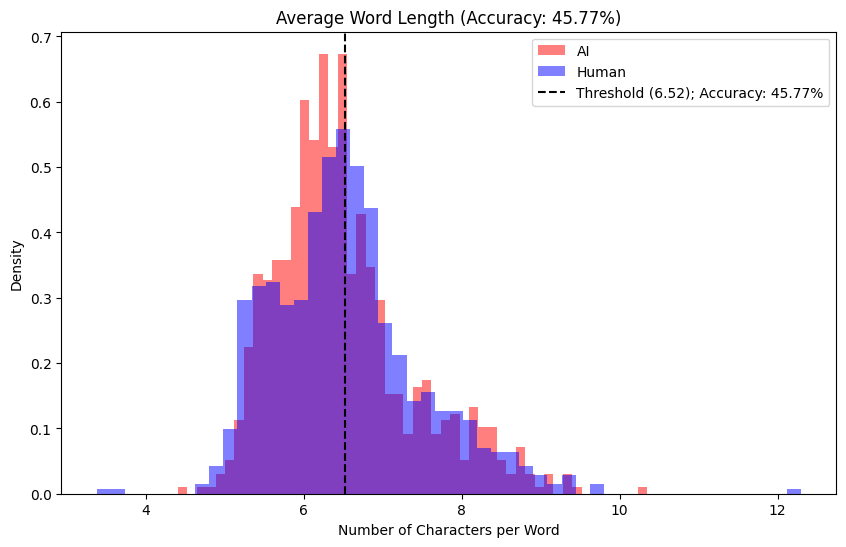

(np.float64(6.518394648829432), 0.4576899320568252)

In [10]:
classify_by_avg_word_length(val_df, labels)

## Type-Token Ratio (TTR)

Via TTR, we measure the lexical diversity in a text. We can calculate it as the ratio of unique words (i.e. types) to the total number of words (i.e. tokens) in a document. A higher TTR indicates higher lexical diversity, and lower TTR means that words are often repeated. Surprisingly, human-written texts seem to be less lexically diverse than AI-generated texts.

In [11]:
def classify_by_ttr(dataframe, labels_mapping):
    ttr_values = []
    for _, row in dataframe.iterrows():
        words = row['text'].split()
        unique_words = set(words)
        ttr = len(unique_words) / len(words) if words else 0
        ttr_values.append((ttr, labels_mapping[row['target']]))  # -> (ttr, label)

    ttrs, labels_list = zip(*ttr_values)
    labels_binary = [1 if label == 'AI' else 0 for label in labels_list]
    fpr, tpr, thresholds = roc_curve(labels_binary, ttrs)
    optimal_idx = abs(tpr - fpr).argmax()
    threshold = thresholds[optimal_idx]

    predictions = ['AI' if ttr >= threshold else 'Human' for ttr in ttrs]
    correct_predictions = sum(1 for pred, actual in zip(predictions, labels_list) if pred == actual)
    accuracy = correct_predictions / len(labels_list)

    plt.figure(figsize=(10, 6))
    plt.hist([ttrs[i] for i in range(len(ttrs)) if labels_list[i] == 'AI'], bins=50, alpha=0.5, label='AI', color='r', density=True)
    plt.hist([ttrs[i] for i in range(len(ttrs)) if labels_list[i] == 'Human'], bins=50, alpha=0.5, label='Human', color='b', density=True)
    plt.axvline(x=threshold, color='k', linestyle='--', label=f'Threshold ({threshold:.2f}); Accuracy: {accuracy:.2%}')
    plt.title(f'Type-Token Ratio (TTR) (Accuracy: {accuracy:.2%})')
    plt.xlabel('Type-Token Ratio (TTR)')
    plt.ylabel('Density')
    plt.legend()
    plt.show()

    return threshold, accuracy

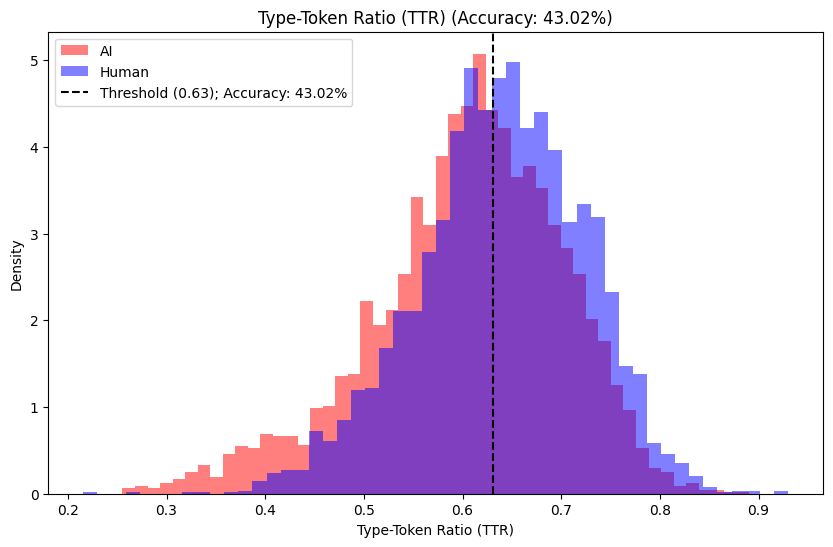

(np.float64(0.6306620209059234), 0.4302356367487424)

In [12]:
classify_by_ttr(train_df, labels)

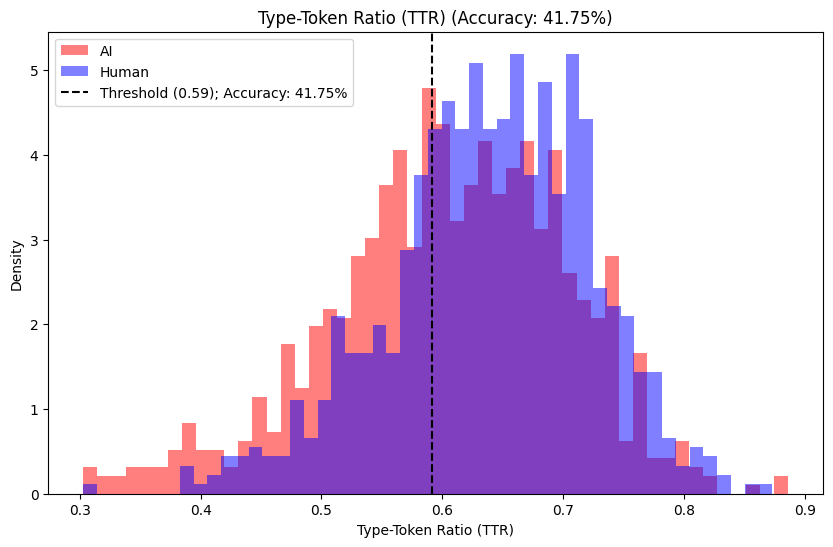

(np.float64(0.591304347826087), 0.4175416924027177)

In [13]:
classify_by_ttr(val_df, labels)

## Stopword Ratio

As we can see, humans seem to use significantly more stopwords than AI models.

In [14]:
def classify_by_stopword_ratio(dataframe, labels_mapping):
    stop_words = set(stopwords.words('english'))
    stopword_ratios = []
    
    for _, row in tqdm(dataframe.iterrows(), total=len(dataframe)):
        words = word_tokenize(row['text'])
        stopword_count = sum(1 for word in words if word.lower() in stop_words)
        ratio = stopword_count / len(words) if len(words) > 0 else 0
        stopword_ratios.append((ratio, labels_mapping[row['target']]))  # -> (ratio, label)

    ratios, labels_list = zip(*stopword_ratios)
    labels_binary = [1 if label == 'AI' else 0 for label in labels_list]
    fpr, tpr, thresholds = roc_curve(labels_binary, ratios)
    optimal_idx = abs(tpr - fpr).argmax()
    threshold = thresholds[optimal_idx]

    predictions = ['AI' if ratio <= threshold else 'Human' for ratio in ratios]
    correct_predictions = sum(1 for pred, actual in zip(predictions, labels_list) if pred == actual)
    accuracy = correct_predictions / len(labels_list)

    plt.figure(figsize=(10, 6))
    plt.hist([ratios[i] for i in range(len(ratios)) if labels_list[i] == 'AI'], bins=50, alpha=0.5, label='AI', color='r', density=True)
    plt.hist([ratios[i] for i in range(len(ratios)) if labels_list[i] == 'Human'], bins=50, alpha=0.5, label='Human', color='b', density=True)
    plt.axvline(x=threshold, color='k', linestyle='--', label=f'Threshold ({threshold:.2f}); Accuracy: {accuracy:.2%}')
    plt.title(f'Stopword Ratio (Accuracy: {accuracy:.2%})')
    plt.xlabel('Stopword Ratio')
    plt.ylabel('Density')
    plt.legend()
    plt.show()

    return threshold, accuracy

100%|██████████| 7554/7554 [00:17<00:00, 432.41it/s]


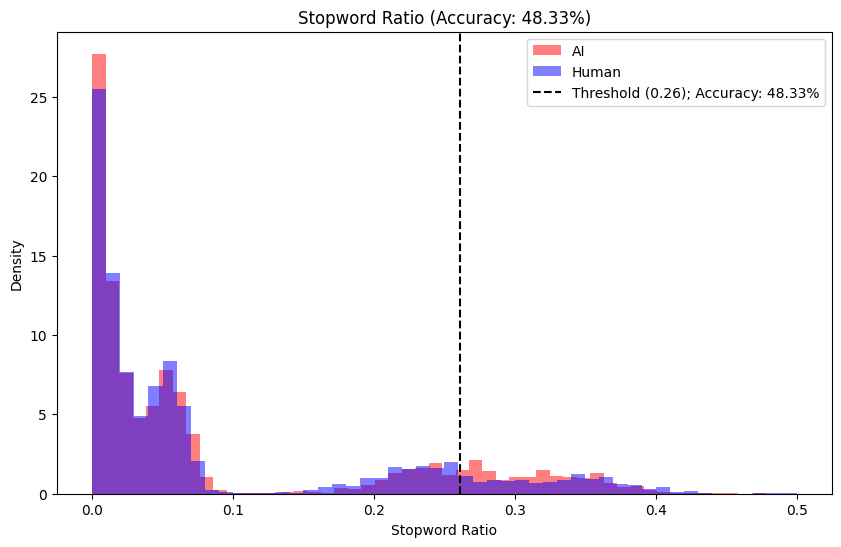

(np.float64(0.26101694915254237), 0.48332009531374104)

In [15]:
classify_by_stopword_ratio(train_df, labels)

100%|██████████| 1619/1619 [00:03<00:00, 450.22it/s]


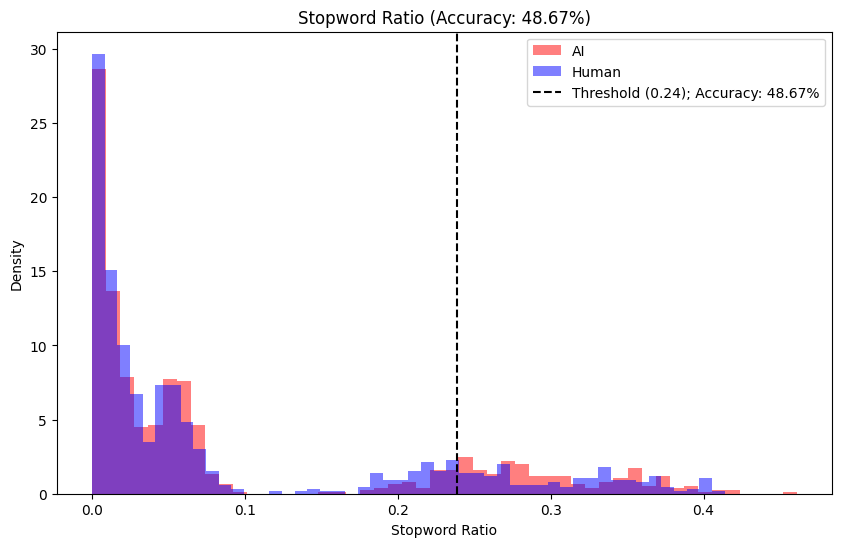

(np.float64(0.23893805309734514), 0.48672019765287217)

In [16]:
classify_by_stopword_ratio(val_df, labels)

## Punctuation Density

It seems like humans use more punctuations than AI models.

In [17]:
def classify_by_punctuation_density(dataframe, labels_mapping):
    punctuation_density = []
    for _, row in tqdm(dataframe.iterrows(), total=len(dataframe)):
        text = row['text']
        punctuation_count = sum(1 for char in text if char in '.,;:!?')
        density = punctuation_count / len(text) if len(text) > 0 else 0
        punctuation_density.append((density, labels_mapping[row['target']]))  # -> (density, label)

    densities, labels_list = zip(*punctuation_density)
    labels_binary = [1 if label == 'AI' else 0 for label in labels_list]
    fpr, tpr, thresholds = roc_curve(labels_binary, densities)
    optimal_idx = abs(tpr - fpr).argmax()
    threshold = thresholds[optimal_idx]

    predictions = ['AI' if density <= threshold else 'Human' for density in densities]
    correct_predictions = sum(1 for pred, actual in zip(predictions, labels_list) if pred == actual)
    accuracy = correct_predictions / len(labels_list)

    plt.figure(figsize=(10, 6))
    plt.hist([densities[i] for i in range(len(densities)) if labels_list[i] == 'AI'], bins=50, alpha=0.5, label='AI', color='r', density=True)
    plt.hist([densities[i] for i in range(len(densities)) if labels_list[i] == 'Human'], bins=50, alpha=0.5, label='Human', color='b', density=True)
    plt.axvline(x=threshold, color='k', linestyle='--', label=f'Threshold ({threshold:.2f}); Accuracy: {accuracy:.2%}')
    plt.title(f'Punctuation Density (Accuracy: {accuracy:.2%})')
    plt.xlabel('Punctuation Density')
    plt.ylabel('Density')
    plt.legend()
    plt.show()

    return threshold, accuracy

100%|██████████| 7554/7554 [00:00<00:00, 8341.43it/s]


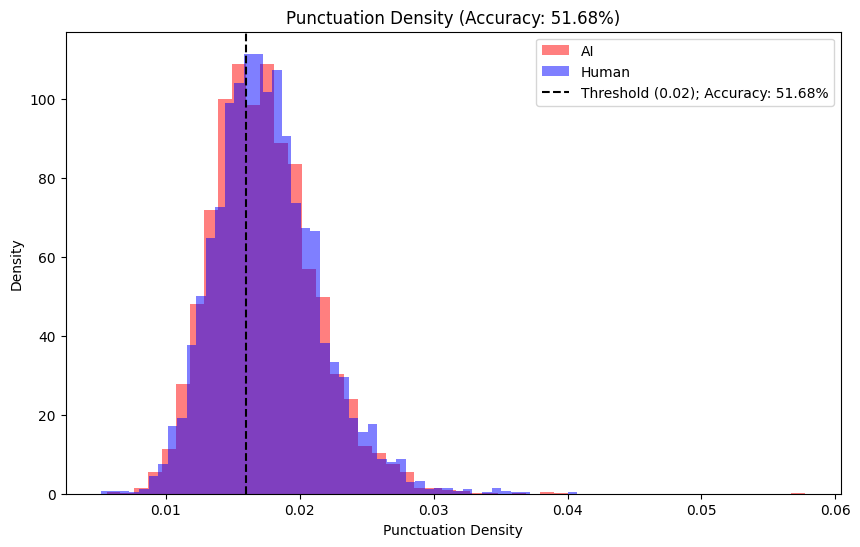

(np.float64(0.015952597994530537), 0.5168122848821817)

In [18]:
classify_by_punctuation_density(train_df, labels)

100%|██████████| 1619/1619 [00:00<00:00, 5761.85it/s]


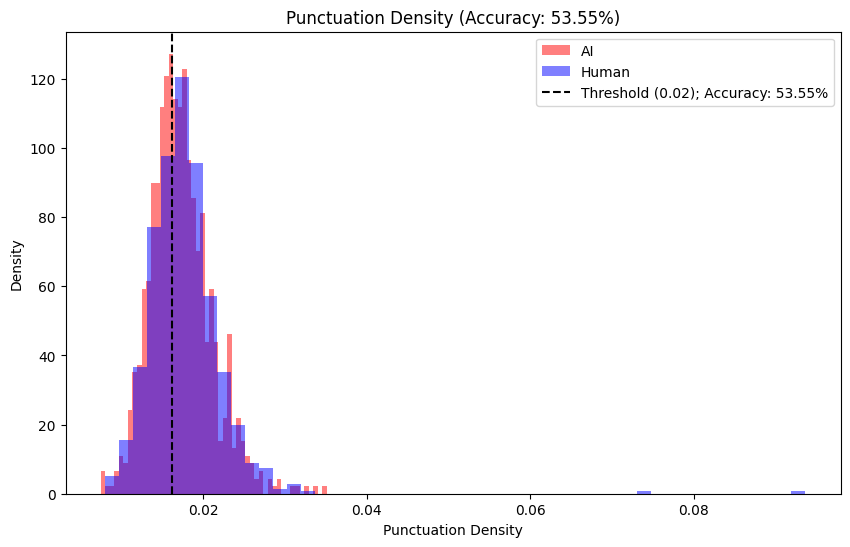

(np.float64(0.01614797416324134), 0.535515750463249)

In [19]:
classify_by_punctuation_density(val_df, labels)

## Inverse Document Frequency (IDF)

With IDF, we measure the informativeness or rarity of a word. A document high high IDF usually uses rare, specific or technical language, and vice versa. As we can see, LLM-generated text seems to use more rare words. This could also be connected to humans using more stopwords (=> very low IDF words), which we showed earlier.

In [20]:
def classify_by_idf(dataframe, labels_mapping):
    texts = dataframe['text'].tolist()
    labels_list = dataframe['target'].map(labels_mapping).tolist()

    vectorizer = TfidfVectorizer(use_idf=True, smooth_idf=True)
    vectorizer.fit(texts)
    idf_values = vectorizer.idf_

    # avg idf per document
    avg_idf_per_doc = []
    for text in tqdm(texts):
        words = text.split()
        avg_idf = np.mean([idf_values[vectorizer.vocabulary_.get(word.lower(), 0)] for word in words if word.lower() in vectorizer.vocabulary_])
        avg_idf_per_doc.append(avg_idf)

    labels_binary = [1 if label == 'AI' else 0 for label in labels_list]
    fpr, tpr, thresholds = roc_curve(labels_binary, avg_idf_per_doc)
    optimal_idx = abs(tpr - fpr).argmax()
    threshold = thresholds[optimal_idx]

    predictions = ['AI' if idf >= threshold else 'Human' for idf in avg_idf_per_doc]
    correct_predictions = sum(1 for pred, actual in zip(predictions, labels_list) if pred == actual)
    accuracy = correct_predictions / len(labels_list)

    plt.figure(figsize=(10, 6))
    plt.hist([avg_idf_per_doc[i] for i in range(len(avg_idf_per_doc)) if labels_list[i] == 'AI'], bins=50, alpha=0.5, label='AI', color='r', density=True)
    plt.hist([avg_idf_per_doc[i] for i in range(len(avg_idf_per_doc)) if labels_list[i] == 'Human'], bins=50, alpha=0.5, label='Human', color='b', density=True)
    plt.axvline(x=threshold, color='k', linestyle='--', label=f'Threshold ({threshold:.2f}); Accuracy: {accuracy:.2%}')
    plt.title(f'Inverse Document Frequency (Accuracy: {accuracy:.2%})')
    plt.xlabel('Average IDF')
    plt.ylabel('Density')
    plt.legend()
    plt.show()

    return threshold, accuracy

100%|██████████| 7554/7554 [00:01<00:00, 4145.31it/s]


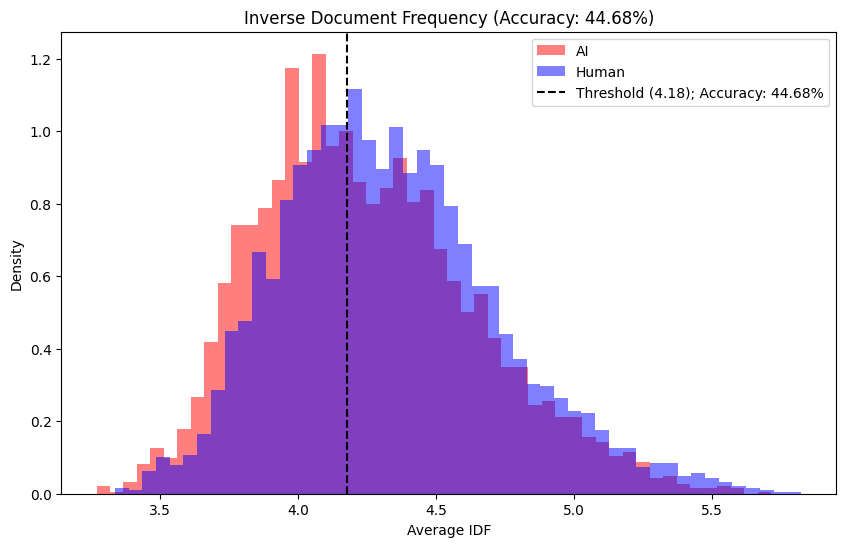

(np.float64(4.1762268779348695), 0.44678316123907863)

In [21]:
classify_by_idf(train_df, labels)

100%|██████████| 1619/1619 [00:00<00:00, 4049.89it/s]


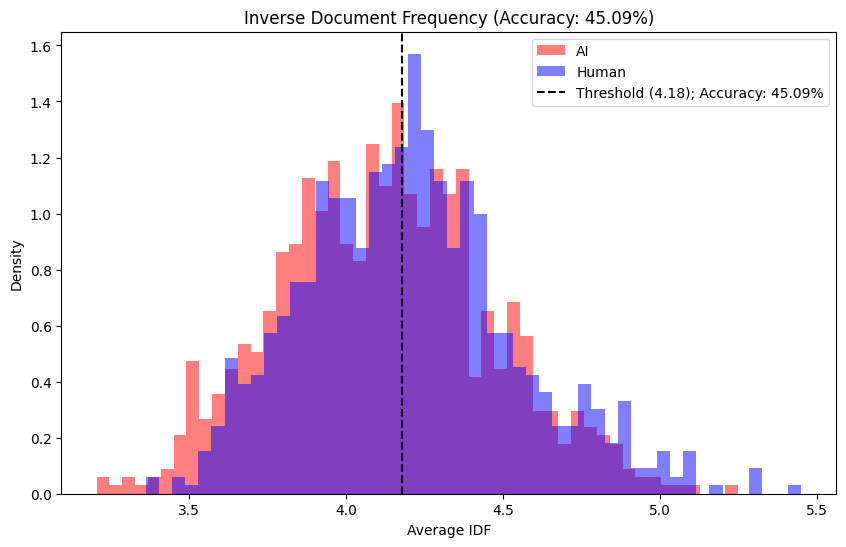

(np.float64(4.17885760484295), 0.4508956145768993)

In [22]:
classify_by_idf(val_df, labels)

## Putting it all together...

Next, we put all such features into a dataframe and train a simple statistical model (i.e. Random Forest) on it.

In [23]:
def extract_features(dataframe):
    stop_words = set(stopwords.words('english'))
    
    vectorizer = TfidfVectorizer(use_idf=True, smooth_idf=True)
    vectorizer.fit(dataframe['text'].tolist())
    idf_values = vectorizer.idf_

    features = []
    for _, row in tqdm(dataframe.iterrows(), total=len(dataframe)):
        text = row['text']
        label = row['target']
        source = row['source']
        language = row['language']

        # document length
        doc_length = len(text.split())

        # avg sentence length
        sentences = text.split('.')
        avg_sentence_length = sum(len(sentence.split()) for sentence in sentences if sentence.strip()) / len(sentences)

        # avg word length
        words = text.split()
        avg_word_length = sum(len(word) for word in words) / len(words) if words else 0

        # type-token ratio (TTR)
        unique_words = set(words)
        ttr = len(unique_words) / len(words) if words else 0

        # stopword ratio
        stopword_count = sum(1 for word in words if word.lower() in stop_words)
        stopword_ratio = stopword_count / len(words) if words else 0

        # punctuation density
        punctuation_count = sum(1 for char in text if char in '.,;:!?')
        punctuation_density = punctuation_count / len(text) if len(text) > 0 else 0
        
        # inverse document frequency (IDF)
        avg_idf = np.mean([idf_values[vectorizer.vocabulary_.get(word.lower(), 0)] for word in words if word.lower() in vectorizer.vocabulary_]) if words else 0

        features.append({
            'doc_length': doc_length,
            'avg_sentence_length': avg_sentence_length,
            'avg_word_length': avg_word_length,
            'ttr': ttr,
            'stopword_ratio': stopword_ratio,
            'punctuation_density': punctuation_density,
            'avg_idf': avg_idf,
            'label': label,
            'source': source,
            'language': language
        })

    return pd.DataFrame(features)

In [24]:
features_train = extract_features(train_df)
features_val = extract_features(val_df)
features_train.head()

100%|██████████| 1619/1619 [00:01<00:00, 1494.26it/s]


,doc_length,avg_sentence_length,avg_word_length,ttr,stopword_ratio,punctuation_density,avg_idf,label,source,language
0,151,25.166667,7.701987,0.675497,0.238411,0.022087,4.168648,1,llama,en
1,280,28.000000,5.946429,0.617857,0.067857,0.013889,4.076896,1,gpt4o,es
2,1112,21.784314,5.499101,0.434353,0.021583,0.013147,4.170429,1,gpt4o,fr
3,449,17.423077,5.489978,0.447661,0.396437,0.017164,4.042272,1,mistral,en
4,179,22.375000,7.195531,0.703911,0.290503,0.020464,3.989669,1,gpt4o,en


In [26]:
y_train = features_train['label'].to_numpy()
X_train = features_train.drop('label', axis=1).drop('source', axis=1).drop('language', axis=1).to_numpy()
y_val = features_val['label'].to_numpy()
X_val = features_val.drop('label', axis=1).drop('source', axis=1).drop('language', axis=1).to_numpy()

In [27]:
rf_model = RandomForestClassifier(random_state=777,
                                  n_estimators=100,
                                  max_depth=None,
                                  max_features='sqrt',
                                  min_samples_split=10,
                                  min_samples_leaf=1)
rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_val)

print("Validation Accuracy:", accuracy_score(y_val, y_pred))
print("\nClassification Report:\n", classification_report(y_val, y_pred))

Validation Accuracy: 0.6429894996911674

Classification Report:
               precision    recall  f1-score   support

           0       0.65      0.58      0.62       794
           1       0.64      0.70      0.67       825

    accuracy                           0.64      1619
   macro avg       0.64      0.64      0.64      1619
weighted avg       0.64      0.64      0.64      1619



ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 2 with shape (7,) and arg 3 with shape (9,).

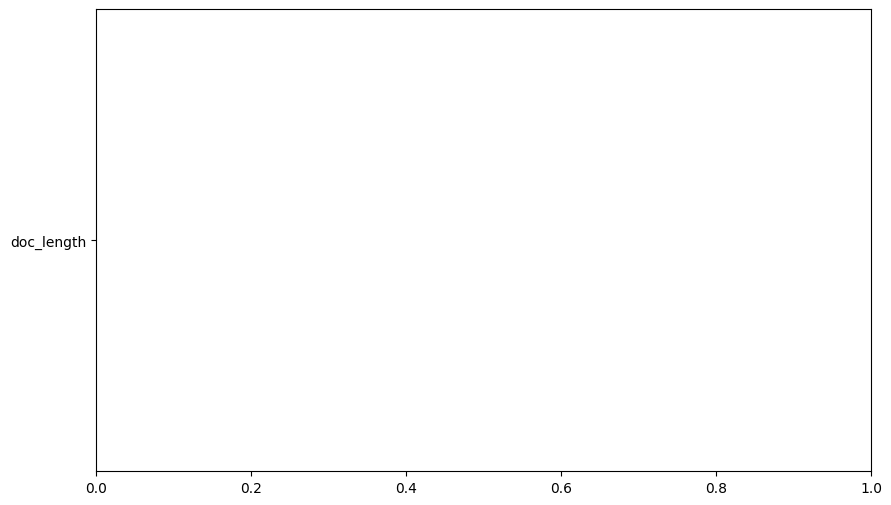

In [29]:
feature_names = features_train.columns[:-1]  # excl label
importances = rf_model.feature_importances_

plt.figure(figsize=(10, 6))
plt.barh(feature_names, importances, color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.show()

In [30]:
features_test = extract_features(test_df)
features_no_dataleak = extract_features(no_dataleak_test_df)
features_test.head()

100%|██████████| 2500/2500 [00:00<00:00, 4857.66it/s]


,doc_length,avg_sentence_length,avg_word_length,ttr,stopword_ratio,punctuation_density,avg_idf,label,source,language
0,378,27.000000,6.526455,0.521164,0.042328,0.017932,4.118216,0,HUMAN,es
1,367,12.433333,6.683924,0.637602,0.065395,0.018092,4.765867,1,gpt4o,de
2,246,30.750000,6.869919,0.601626,0.256098,0.013437,4.218659,0,HUMAN,en
3,373,23.375000,7.131367,0.662198,0.249330,0.024406,4.126225,1,gpt4o,en
4,254,28.222222,5.814961,0.598425,0.051181,0.016185,4.263056,1,llama,es


In [31]:
from sklearn.model_selection import ParameterGrid

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

best_params = None
best_accuracy = 0

for params in tqdm(ParameterGrid(param_grid)):
    model = RandomForestClassifier(random_state=777, **params)
    model.fit(X_train, y_train)
    y_pred_val = model.predict(X_val)
    accuracy = accuracy_score(y_val, y_pred_val)
    
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_params = params

print("Best Hyperparameters:", best_params)
print("Best Validation Accuracy:", best_accuracy)

100%|██████████| 81/81 [01:53<00:00,  1.40s/it]

Best Hyperparameters: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 200}
Best Validation Accuracy: 0.6714021000617665


In [32]:
rf_model = RandomForestClassifier(random_state=777, **best_params)
rf_model.fit(X_train, y_train)

y_pred_val_best = rf_model.predict(X_val)

print("Validation Accuracy with Best Params:", accuracy_score(y_val, y_pred_val_best))
print("\nClassification Report:\n", classification_report(y_val, y_pred_val_best))

Validation Accuracy with Best Params: 0.6714021000617665

Classification Report:
               precision    recall  f1-score   support

           0       0.68      0.62      0.65       794
           1       0.66      0.72      0.69       825

    accuracy                           0.67      1619
   macro avg       0.67      0.67      0.67      1619
weighted avg       0.67      0.67      0.67      1619



In [35]:
y_test = features_test['label'].to_numpy()
X_test = features_test.drop('label', axis=1).drop('source', axis=1).drop('language', axis=1).to_numpy()
y_no_dataleak = features_no_dataleak['label'].to_numpy()
X_no_dataleak = features_no_dataleak.drop('label', axis=1).drop('source', axis=1).drop('language', axis=1).to_numpy()

In [36]:
y_pred = rf_model.predict(X_test)

print("Validation Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Validation Accuracy: 0.644224830142063

Classification Report:
               precision    recall  f1-score   support

           0       0.66      0.59      0.62       805
           1       0.63      0.70      0.66       814

    accuracy                           0.64      1619
   macro avg       0.65      0.64      0.64      1619
weighted avg       0.65      0.64      0.64      1619



In [37]:
y_pred = rf_model.predict(X_no_dataleak)

print("Validation Accuracy:", accuracy_score(y_no_dataleak, y_pred))
print("\nClassification Report:\n", classification_report(y_no_dataleak, y_pred))

Validation Accuracy: 0.6188

Classification Report:
               precision    recall  f1-score   support

           0       0.63      0.56      0.60      1250
           1       0.61      0.67      0.64      1250

    accuracy                           0.62      2500
   macro avg       0.62      0.62      0.62      2500
weighted avg       0.62      0.62      0.62      2500



## Create 5 Splits

In [39]:
import os
SAVE_PATH = "results/baseline"

for i in range(1,6):
    rf_model = RandomForestClassifier(random_state=i, **best_params)
    rf_model.fit(X_train, y_train)

    y_pred_val_best = rf_model.predict(X_test)
    
    acc_val = accuracy_score(y_test, y_pred_val_best)
    print(f"Test Accuracy: {acc_val}")
    
    test_csv = pd.DataFrame({
        'source': features_val['source'],
        'language': features_val['language'],
        'Prediction': y_pred_val_best,
        'Ground Truth': y_test
    })
    
    y_pred_val_best = rf_model.predict(X_no_dataleak)
    
    acc_no_dataleak = accuracy_score(y_no_dataleak, y_pred_val_best)
    print(f"Test No Data Leak Accuracy: {acc_no_dataleak}")
    
    test_no_dataleak = pd.DataFrame({
        'source': features_no_dataleak['source'],
        'language': features_no_dataleak['language'],
        'Prediction': y_pred_val_best,
        'Ground Truth': y_no_dataleak
    })
    
    csv_savepath = f"{SAVE_PATH}/{i}"
    os.makedirs(csv_savepath, exist_ok=True)
    
    test_csv.to_csv(f"{csv_savepath}/results_test.csv", index=False)
    test_no_dataleak.to_csv(f"{csv_savepath}/results_no_dataleak.csv", index=False)
    
    print(f"CSV {i} saved.")

Test Accuracy: 0.644224830142063
Test No Data Leak Accuracy: 0.63
CSV 1 saved.
Test Accuracy: 0.6423718344657195
Test No Data Leak Accuracy: 0.6228
CSV 2 saved.
Test Accuracy: 0.6355775169857937
Test No Data Leak Accuracy: 0.6168
CSV 3 saved.
Test Accuracy: 0.634342186534898
Test No Data Leak Accuracy: 0.622
CSV 4 saved.
Test Accuracy: 0.6355775169857937
Test No Data Leak Accuracy: 0.62
CSV 5 saved.
